In [22]:
import sys
import warnings
import re

warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "../data"

In [23]:
# Load excel file
df = pd.read_excel(DATA_PATH + "/consumo_material_clean.xlsx")

## Preprocessing

In [3]:
# Separate code into two columns
new_columns = df["P_code"].str.extract(r"([a-zA-Z]+)([0-9]+)", expand=False)
df["P_code_CLASS"] = new_columns[0]
df["P_code_NUM"] = new_columns[1]
df.drop(columns=["P_code"], inplace=True)

In [4]:
# P_date to datetime in day/month/year format
df["P_date"] = pd.to_datetime(df["P_date"], dayfirst=True)
df.sort_values(by=["P_date"], inplace=True)
df.reset_index(drop=True, inplace=True)

C:\Users\AMAR2\AppData\Local\Temp\ipykernel_38432\3581088518.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["P_date"] = pd.to_datetime(df["P_date"], dayfirst=True)


In [5]:
# assert all rows in H_code follow number-number-number format
def fix_origen_typos(origen_string):
    numbers = re.findall(r"[0-9]+", origen_string)
    return "-".join(numbers)


df["H_code"] = df["H_code"].apply(fix_origen_typos)

In [6]:
# separate H_code in three columns by '-'
origin_separated_columns = df["H_code"].str.split("-", expand=True)
df["PURCHASING_REGION"] = origin_separated_columns[0]
df["PURCHASING_HOSPITAL"] = origin_separated_columns[1]
df["PURCHASING_DEPARTMENT"] = origin_separated_columns[2]
df.drop(columns=["H_code"], inplace=True)

In [7]:
# remove /year from N_Order
# df["N_Order_PEDIDO"] = df["N_Order"].str.split("/", expand=True)[0]
# df.drop(columns=["N_Order"], inplace=True)

In [8]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [9]:
# sample random row from dataset
df.sample(1)

,P_date,N_Order,R_no,N_product_purchased,N_units,Cost,Total_product_purchase,Type_purchase,Type_logistic,PRODUCTO,P_code_CLASS,P_code_NUM,PURCHASING_REGION,PURCHASING_HOSPITAL,PURCHASING_DEPARTMENT
15231,2023-08-21,1003288/23,178567.1,100,10,62.59,625.9,Minor purchase,TRANSIT,APOSITO DE FIBRAS DE POLIACRILATO C/PLATA-3,E,99808,0,14,32


In [10]:
columns = ["P_date", "Type_purchase", "N_product_purchased"]
sample_df = df[df["PURCHASING_HOSPITAL"] == "10"]
sample_df = sample_df[sample_df["P_code_NUM"] == "66071"]
sample_df = sample_df[columns]
sample_df.head()

,P_date,Type_purchase,N_product_purchased
4,2015-01-05,Minor purchase,160
63,2015-01-26,Minor purchase,160
107,2015-02-16,Minor purchase,160
139,2015-02-27,Minor purchase,160
192,2015-03-18,Minor purchase,190


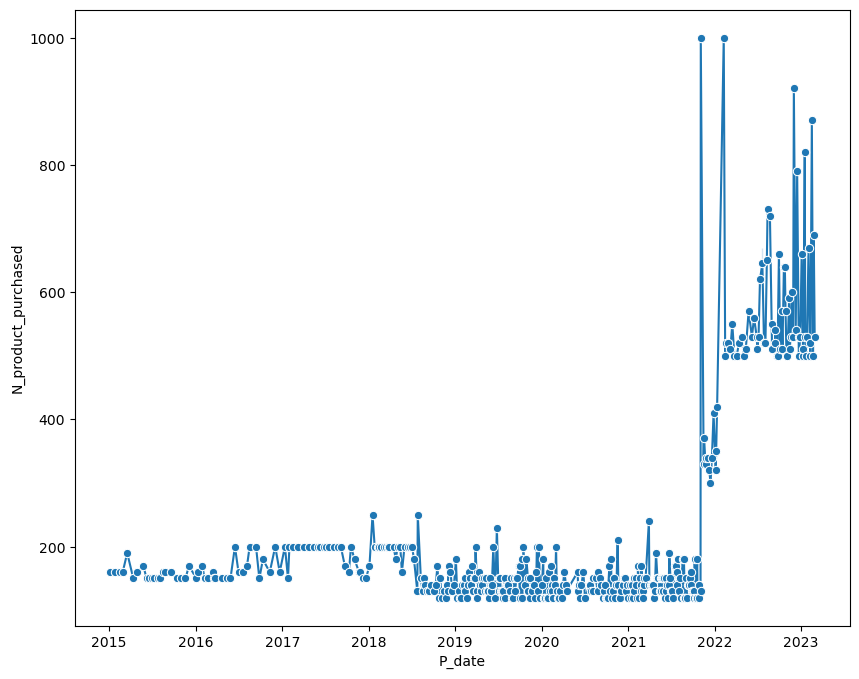

In [11]:
plt.figure(figsize=(10, 8))
sns.lineplot(x="P_date", y="N_product_purchased", data=sample_df, marker="o")
plt.show()

In [12]:
# basic date features
def generate_date_features(df):
    df["YEAR"] = df["P_date"].dt.year
    df["MONTH"] = np.sin(2 * np.pi * df["P_date"].dt.month / 12)
    df["DAYOFMONTH"] = np.sin(2 * np.pi * df["P_date"].dt.day / 30)
    df["DAYOFYEAR"] = np.sin(2 * np.pi * df["P_date"].dt.dayofyear / 365)
    return df


sample_df = generate_date_features(sample_df)

In [13]:
sample_df = pd.get_dummies(sample_df, columns=["Type_purchase"], prefix="Type_purchase")

In [14]:
def add_timeseries_features(df):
    df["ROLLING_MEAN_3M"] = df["N_product_purchased"].rolling(90).mean()
    df["WEIGHTED_MEAN_3M"] = (
        df["N_product_purchased"]
        .rolling(90)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )
    df["EWMA_3M"] = df["N_product_purchased"].ewm(span=90).mean()
    df["ROLLING_MEAN_6M"] = df["N_product_purchased"].rolling(180).mean()
    df["WEIGHTED_MEAN_6M"] = (
        df["N_product_purchased"]
        .rolling(180)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )
    df["ROLLING_MEAN_1Y"] = df["N_product_purchased"].rolling(365).mean()
    df["WEIGHTED_MEAN_1Y"] = (
        df["N_product_purchased"]
        .rolling(365)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )
    # df["ROLLING_MEAN_1M"] = df["N_product_purchased"].rolling(30).mean()
    return df


sample_df = add_timeseries_features(sample_df)

In [15]:
sample_df.head()

,P_date,N_product_purchased,YEAR,MONTH,DAYOFMONTH,DAYOFYEAR,Type_purchase_Major purchase,Type_purchase_Minor purchase,ROLLING_MEAN_3M,WEIGHTED_MEAN_3M,EWMA_3M,ROLLING_MEAN_6M,WEIGHTED_MEAN_6M,ROLLING_MEAN_1Y,WEIGHTED_MEAN_1Y
4,2015-01-05,160,2015,0.500000,0.866025,0.085965,False,True,NaN,NaN,160.000000,NaN,NaN,NaN,NaN
63,2015-01-26,160,2015,0.500000,-0.743145,0.432776,False,True,NaN,NaN,160.000000,NaN,NaN,NaN,NaN
107,2015-02-16,160,2015,0.866025,-0.207912,0.723644,False,True,NaN,NaN,160.000000,NaN,NaN,NaN,NaN
139,2015-02-27,160,2015,0.866025,-0.587785,0.840618,False,True,NaN,NaN,160.000000,NaN,NaN,NaN,NaN
192,2015-03-18,190,2015,1.000000,-0.587785,0.970064,False,True,NaN,NaN,166.269596,NaN,NaN,NaN,NaN


## Baseline modelling

In [16]:
train = sample_df[sample_df["YEAR"] < 2023]
X_train = train.drop(columns=["N_product_purchased", "P_date"])
y_train = train["N_product_purchased"]

columns_for_plot = X_train.columns.tolist()

test = sample_df[sample_df["YEAR"] == 2023]
X_test = test.drop(columns=["N_product_purchased", "P_date"])
y_test = test["N_product_purchased"]

In [17]:
X_test.head()

,YEAR,MONTH,DAYOFMONTH,DAYOFYEAR,Type_purchase_Major purchase,Type_purchase_Minor purchase,ROLLING_MEAN_3M,WEIGHTED_MEAN_3M,EWMA_3M,ROLLING_MEAN_6M,WEIGHTED_MEAN_6M,ROLLING_MEAN_1Y,WEIGHTED_MEAN_1Y
13362,2023,0.5,0.587785,0.051620,False,True,432.000000,525.362637,462.540381,287.222222,383.108042,219.835616,273.932330
13390,2023,0.5,0.951057,0.154309,False,True,436.222222,526.857143,463.363767,289.166667,385.459177,220.657534,275.463283
13407,2023,0.5,0.866025,0.171293,False,True,439.888889,528.478632,464.388857,291.166667,387.899325,221.616438,277.044390
13462,2023,0.5,-0.207912,0.271958,False,True,447.666667,536.832723,472.205369,295.000000,393.742787,223.315068,280.314245
13485,2023,0.5,-0.587785,0.304921,False,True,452.222222,538.642247,473.475721,297.055556,396.339472,224.356164,281.990119


In [18]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

# group by year
group_kfold = GroupKFold(n_splits=8)
groups = X_train["YEAR"]

# train model
model = XGBRegressor(random_state=42, n_estimators=500)

val_losses = []
test_losses = []

for idx, (train_index, test_index) in enumerate(
    group_kfold.split(X_train, y_train, groups)
):
    X_train_group, X_val_group = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_group, y_val_group = y_train.iloc[train_index], y_train.iloc[test_index]

    model.fit(X_train_group, y_train_group)

    y_val_pred = model.predict(X_val_group)
    val_loss = mean_squared_error(y_val_group, y_val_pred, squared=False)
    val_losses.append(val_loss)

    y_test_pred = model.predict(X_test)
    test_loss = mean_squared_error(y_test, y_test_pred, squared=False)
    test_losses.append(test_loss)

    print(
        "FOLD",
        idx,
        "| Val RMSE:",
        val_loss,
        "| Test RMSE:",
        test_loss,
        "| YEARS IN VAL:",
        X_val_group["YEAR"].unique(),
    )

print("MEAN VAL RMSE:", np.mean(val_losses))
print("MEAN TEST RMSE:", np.mean(test_losses))

FOLD 0 | Val RMSE: 106.44120238378292 | Test RMSE: 108.68777903940419 | YEARS IN VAL: [2021]
FOLD 1 | Val RMSE: 26.07195914714902 | Test RMSE: 97.29631564744264 | YEARS IN VAL: [2019]
FOLD 2 | Val RMSE: 257.5960901258172 | Test RMSE: 122.23162802572152 | YEARS IN VAL: [2020]
FOLD 3 | Val RMSE: 262.5378657264679 | Test RMSE: 237.71732662369823 | YEARS IN VAL: [2022]
FOLD 4 | Val RMSE: 219.53512968272756 | Test RMSE: 85.38920333893277 | YEARS IN VAL: [2018]
FOLD 5 | Val RMSE: 23.633363697568985 | Test RMSE: 90.07149255996487 | YEARS IN VAL: [2017]
FOLD 6 | Val RMSE: 21.415746670012805 | Test RMSE: 89.48955137426569 | YEARS IN VAL: [2016]
FOLD 7 | Val RMSE: 25.353353742111874 | Test RMSE: 87.47097251523174 | YEARS IN VAL: [2015]
MEAN VAL RMSE: 117.82308889695479
MEAN TEST RMSE: 114.7942836405827


Baseline model loss (XGBRegressor):
- Trained using GroupKFold with years as groups
- MEAN VAL RMSE: 87.12345687200653
- MEAN TEST RMSE: 104.92861512120264

In [19]:
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
test_loss = mean_squared_error(y_test, y_test_pred, squared=False)
mape_error = mean_absolute_percentage_error(y_test, y_test_pred)
print("FINAL TEST RMSE:", test_loss, "| MAPE:", mape_error)

FINAL TEST RMSE: 85.77292548507867 | MAPE: 0.08761575296872581


FINAL TEST RMSE: 83.62435512074963

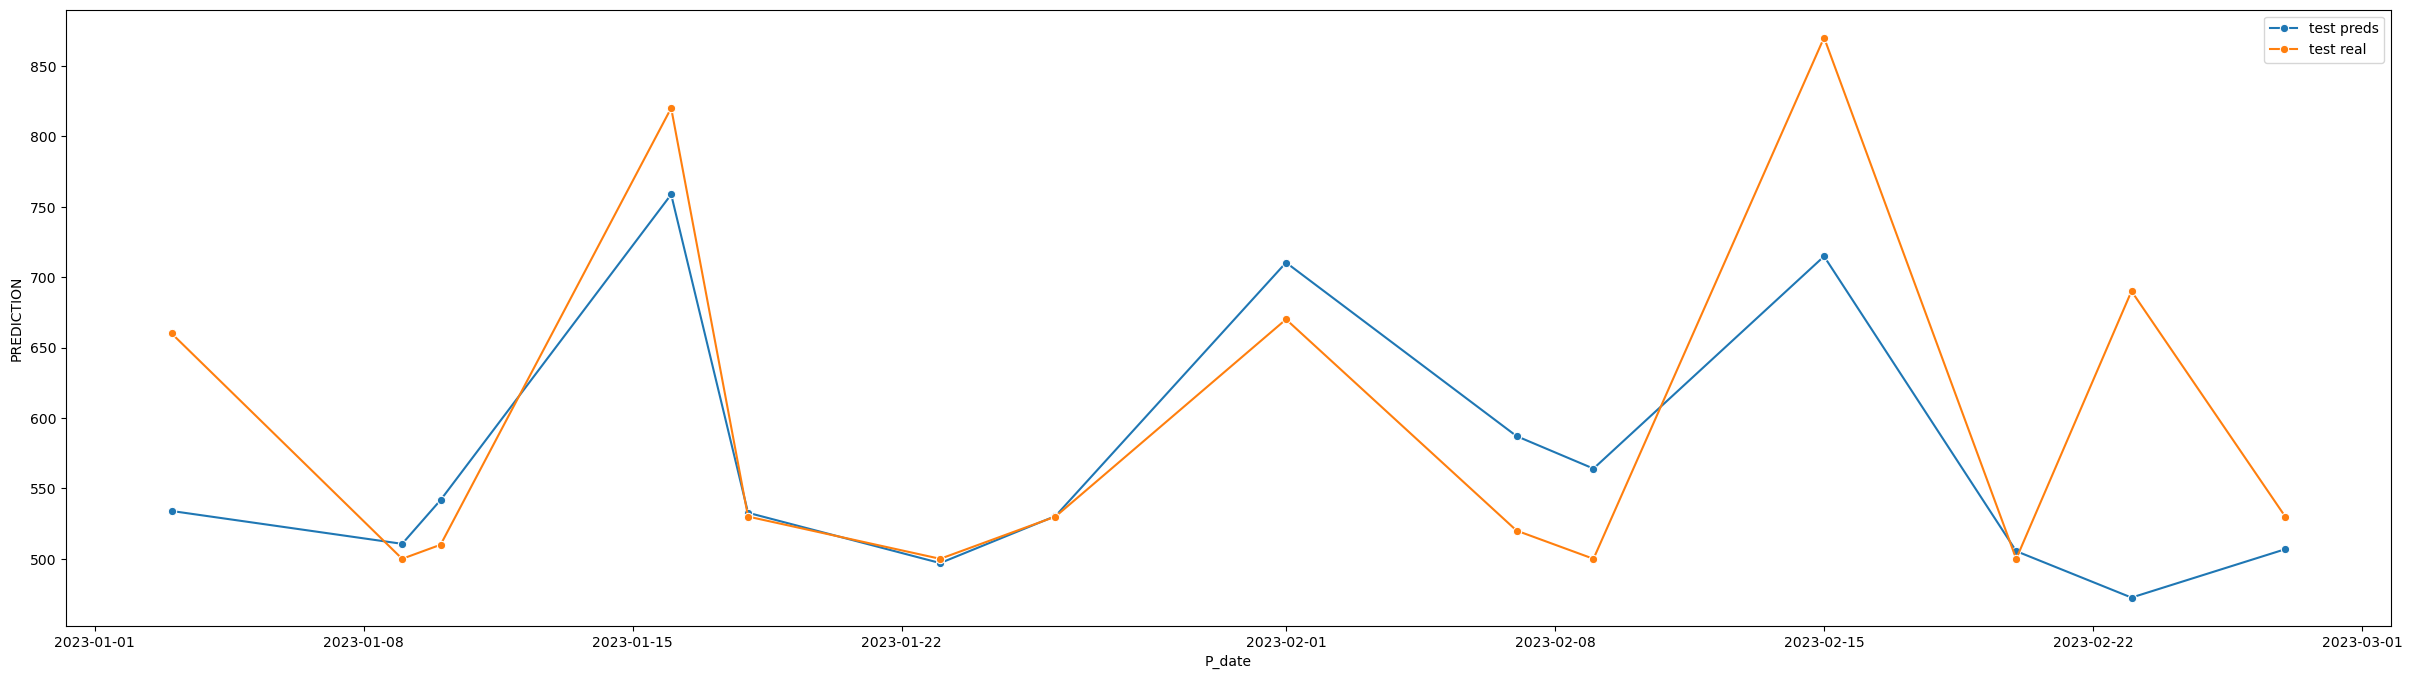

In [20]:
plt.figure(figsize=(30, 8))
X_train["PREDICTION"] = model.predict(X_train)
X_train["REAL"] = y_train
X_train["P_date"] = train["P_date"]

X_test["PREDICTION"] = y_test_pred
X_test["REAL"] = y_test
X_test["P_date"] = test["P_date"]

# sns.lineplot(
#     x="P_date", y="PREDICTION", data=X_train, marker="o", label="train preds"
# )
# sns.lineplot(x="P_date", y="REAL", data=X_train, marker="o", label="train real")
sns.lineplot(
    x="P_date", y="PREDICTION", data=X_test, marker="o", label="test preds"
)
sns.lineplot(x="P_date", y="REAL", data=X_test, marker="o", label="test real")
plt.legend()
plt.show()

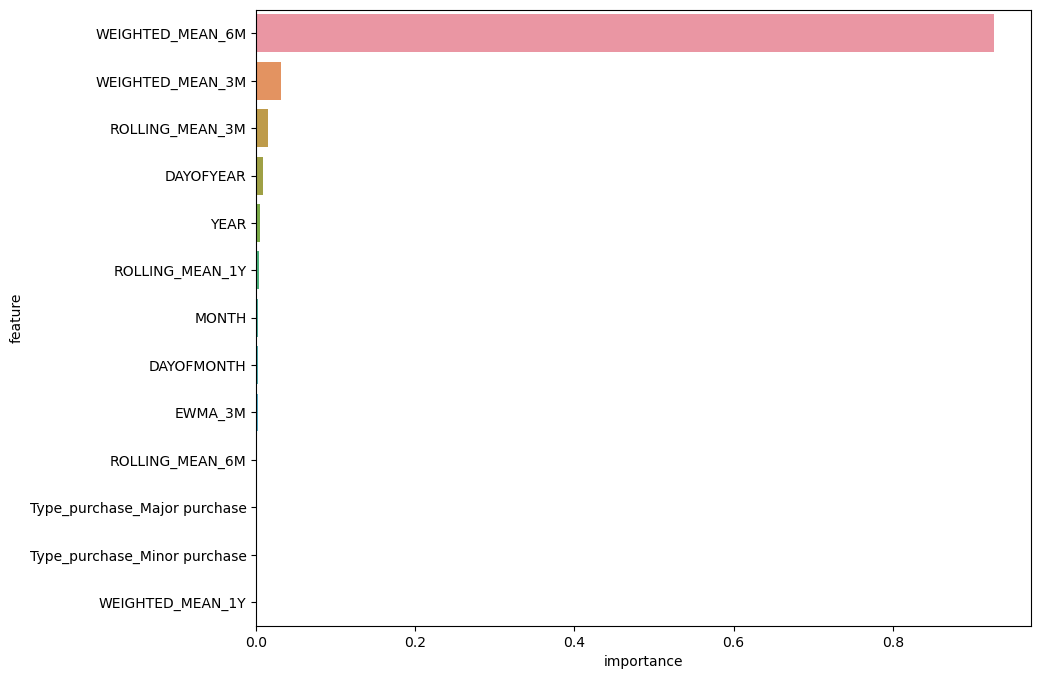

In [21]:
# model feature importance
importances = pd.DataFrame(
    {"feature": columns_for_plot, "importance": model.feature_importances_}
)
importances.sort_values(by="importance", ascending=False, inplace=True)
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=importances)
plt.show()